In [ ]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 376 kB 35.4 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=bf3d91c758af98cb3b13dddb4f99970c7cac994e619fcabc180b2a4bf9674958
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=075614276c4cb406835080f6e3e281c95ee524190dd77535f418d6011cb4d188
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import torch
import nibabel as nib
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def dice_loss(inputs, targets, smooth=1): 
    
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
    return 1 - dice

In [ ]:
# https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

In [ ]:
class BratsDataset(Dataset):
    def __init__(self, img_path, label_path, slice_num=155):

        self.slice_num = slice_num

        self.files = [f for f in os.listdir(img_path) if not f.startswith('.')]

        self.data_list = [(nib.load(os.path.join(img_path, f)), nib.load(os.path.join(label_path, f))) for f in self.files]

    def __len__(self):
        return len(self.data_list) * self.slice_num

    def __getitem__(self, idx):
        to_t = transforms.ToTensor()

        img_num = idx // self.slice_num
        slice_num = idx % self.slice_num

        # print(f"idx = {idx}, img = {img_num}, slice = {slice_num}")

        nii_img = self.data_list[img_num][0]
        nii_label = self.data_list[img_num][1]
        
        # data = nii_img.get_fdata()
        # Min-Max Scaling
        
        data = np.asarray(nii_img.dataobj)[7:231,7:231,slice_num,:]

        # print(data)

        for i in range(4):
            max = np.max(data[:,:,i])
            min = np.min(data[:,:,i])
            if max != min:
                data[:,:,i] = (data[:,:,i] - np.min(data[:,:,i])) / (np.max(data[:,:,i]) - np.min(data[:,:,i])) * 255
                # print(np.isnan(data[:,:,i]).sum())
                
        
        data = to_t(data)

        target = np.asarray(nii_label.dataobj, dtype='int64')[7:231,7:231,slice_num]

        # print(target.max())

        target = to_t(target)

        return data, target

In [ ]:
image_root = "/content/drive/MyDrive/Task01_BrainTumour/imagesTr"
label_root = "/content/drive/MyDrive/Task01_BrainTumour/labelsTr"

dataset = BratsDataset(image_root, label_root)

In [ ]:
sample = dataset.__getitem__(2367)[0]
label = dataset.__getitem__(2367)[1]

In [ ]:
model = UNet(n_channels = 4, n_classes = 4)

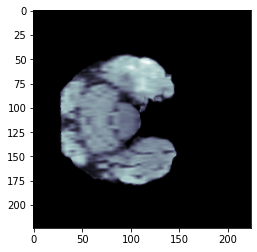

In [ ]:
plt.imshow(sample[0,:,:], cmap='bone')

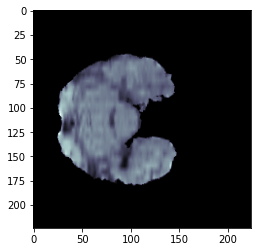

In [ ]:
plt.imshow(sample[1,:,:], cmap='bone')

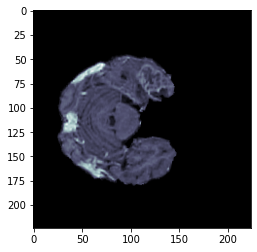

In [ ]:
plt.imshow(sample[2,:,:], cmap='bone')

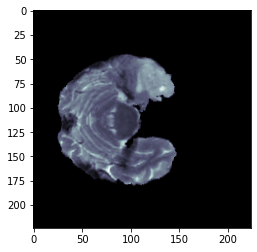

In [ ]:
plt.imshow(sample[3,:,:], cmap='bone')

3


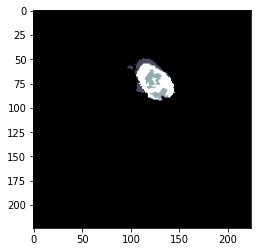

In [ ]:
print(int(label.max()))
plt.imshow(label.squeeze(), cmap='bone')

In [ ]:
train_size = 1000
idxs = np.random.choice(range(len(dataset)), size=train_size, replace=False, p=None)
train_set =  torch.utils.data.Subset(dataset, idxs)

test_size = 40
idxs = np.random.choice(range(len(dataset)), size=test_size, replace=False, p=None)
test_set = torch.utils.data.Subset(dataset, idxs)

print(train_set)

In [ ]:
len(dataset)

75020

In [ ]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(train_set, batch_size=1, shuffle=True)

In [ ]:
len(train_loader)

125

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [ ]:
epochs = 5
lr = 5e-6

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

In [ ]:
model.to(device)

In [ ]:
dice = []
hausdorff = []

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from scipy.spatial.distance import directed_hausdorff

for epoch in range(epochs):
    print("===============")
    print(f"Epoch: {epoch + 1}")
    print("===============")


    loss_tot = dice_tot = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.cuda(), labels.cuda()

        if i % 10 == 0: 
            print("*", end = "")

        out = model(inputs)

        loss = criterion(out, labels.squeeze().long())

        loss_tot += loss
        

        metric_out = F.softmax(out, dim=1)
        metric_out = out.argmax(axis=1).cpu()
        metric_labels = labels.squeeze().cpu()

        #print(metric_out.shape, metric_labels.shape)

        dice_tot += dice_loss(metric_out, metric_labels.long())

        loss.backward()
        optimizer.step()

    dice.append(dice_tot / len(train_loader))
    #hausdorff.append(haus_tot / len(train_loader))

    print(f"\nLoss: {loss_tot / len(train_loader)}")
    print(f"\nDice Loss: {dice_tot / len(train_loader)}")
    #print(f"\nLoss: {haus_tot / len(train_loader)}")



### SAVE MODEL

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Saved_Model/MedicalImaging3.pt')

In [ ]:
torch.save(model, '/content/drive/MyDrive/Saved_Model/MedicalImagingFullModel3.pt')

### LOAD MODEL

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Saved_Model/MedicalImaging3.pt'))
model.eval()

### TESTING

In [ ]:
model_test = torch.load('/content/drive/MyDrive/Saved_Model/MedicalImagingFullModel2.pt')
model_test.eval()
model_test.to(device)

torch.Size([1, 4, 224, 224])
tensor([[[[0.3850, 0.5007, 0.5480,  ..., 0.5290, 0.5070, 0.4187],
          [0.4754, 0.7607, 0.6513,  ..., 0.7983, 0.6203, 0.5874],
          [0.5351, 0.8007, 0.7526,  ..., 0.8565, 0.7235, 0.6613],
          ...,
          [0.5060, 0.8259, 0.6958,  ..., 0.8552, 0.6528, 0.6371],
          [0.5136, 0.7890, 0.6998,  ..., 0.8392, 0.6730, 0.6472],
          [0.4605, 0.6846, 0.5704,  ..., 0.7142, 0.5707, 0.5040]],

         [[0.2293, 0.2088, 0.1477,  ..., 0.1839, 0.1465, 0.1659],
          [0.1950, 0.1185, 0.1516,  ..., 0.1041, 0.1483, 0.1526],
          [0.1696, 0.1028, 0.0815,  ..., 0.0752, 0.0831, 0.1319],
          ...,
          [0.1620, 0.0924, 0.1237,  ..., 0.0836, 0.1256, 0.1499],
          [0.1599, 0.1102, 0.1012,  ..., 0.0826, 0.1078, 0.1345],
          [0.1290, 0.1270, 0.1271,  ..., 0.1295, 0.1329, 0.1979]],

         [[0.1895, 0.1616, 0.1522,  ..., 0.1658, 0.1846, 0.2186],
          [0.1829, 0.0747, 0.1196,  ..., 0.0603, 0.1459, 0.1354],
          [0.

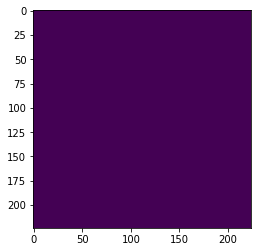

In [ ]:
with torch.no_grad(): 
    for i, (input, label) in enumerate(test_loader): 
        input, label = input.cuda(), label.cuda()
        out = model(input)

        print(out.shape)

        out = F.softmax(out, dim=1)

        print(out)

        break

plt.imshow(out.squeeze().argmax(axis=0).cpu())



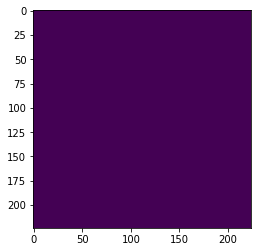

In [ ]:
plt.imshow(label.squeeze().cpu())

In [ ]:
float(out.max())

#plt.imshow(out.squeeze().argmax(axis=0).cpu())

1.0

### VISUALISATION

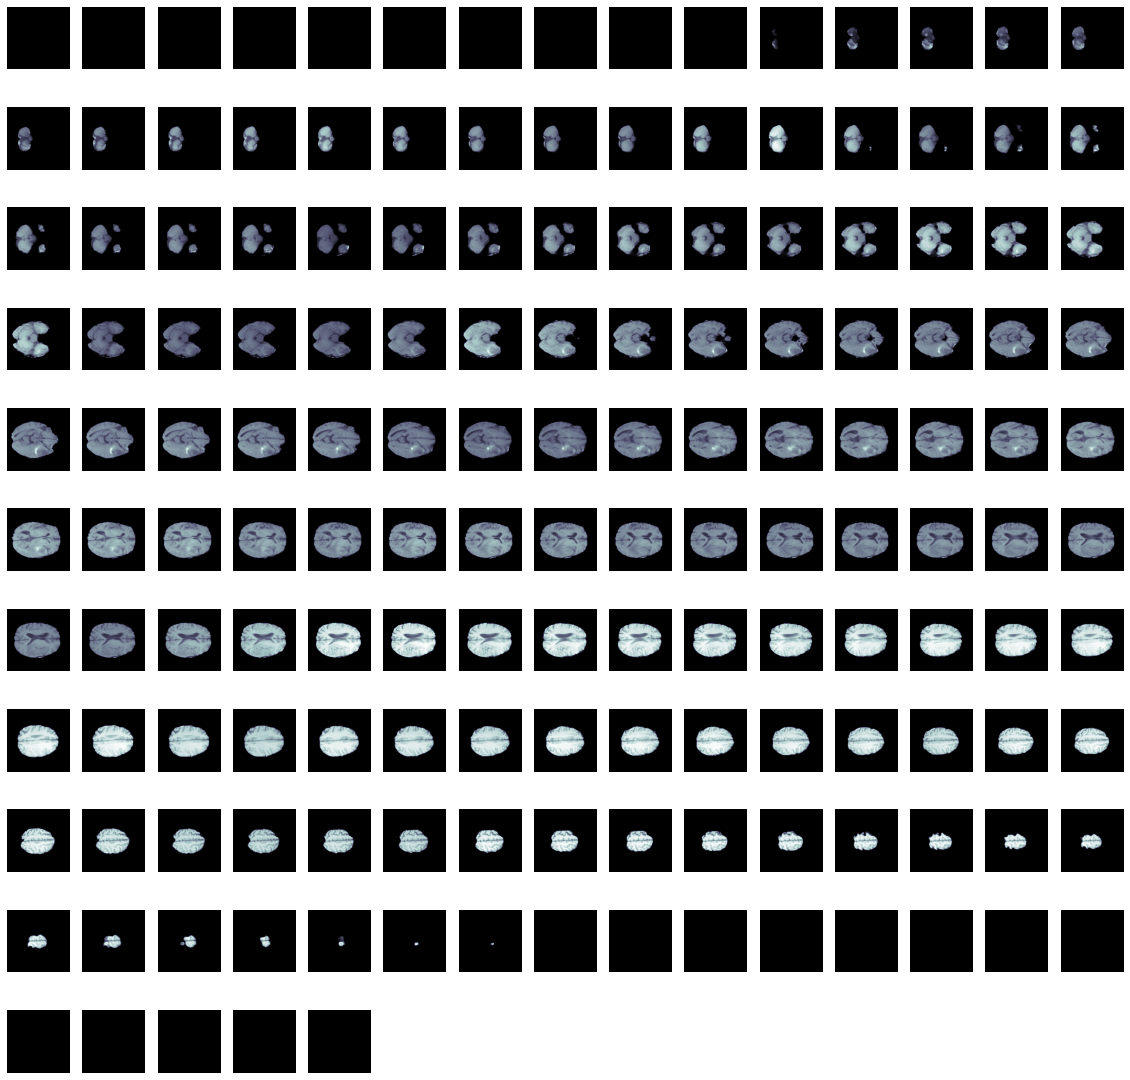

In [ ]:
# Full brain MRI for single sample 

fig = plt.figure(figsize=(20,20))

rows = 11
cols = 15

for i in range(155):

    img, _ = dataset.__getitem__(i)
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img.squeeze(),cmap="bone")
    plt.axis('off')

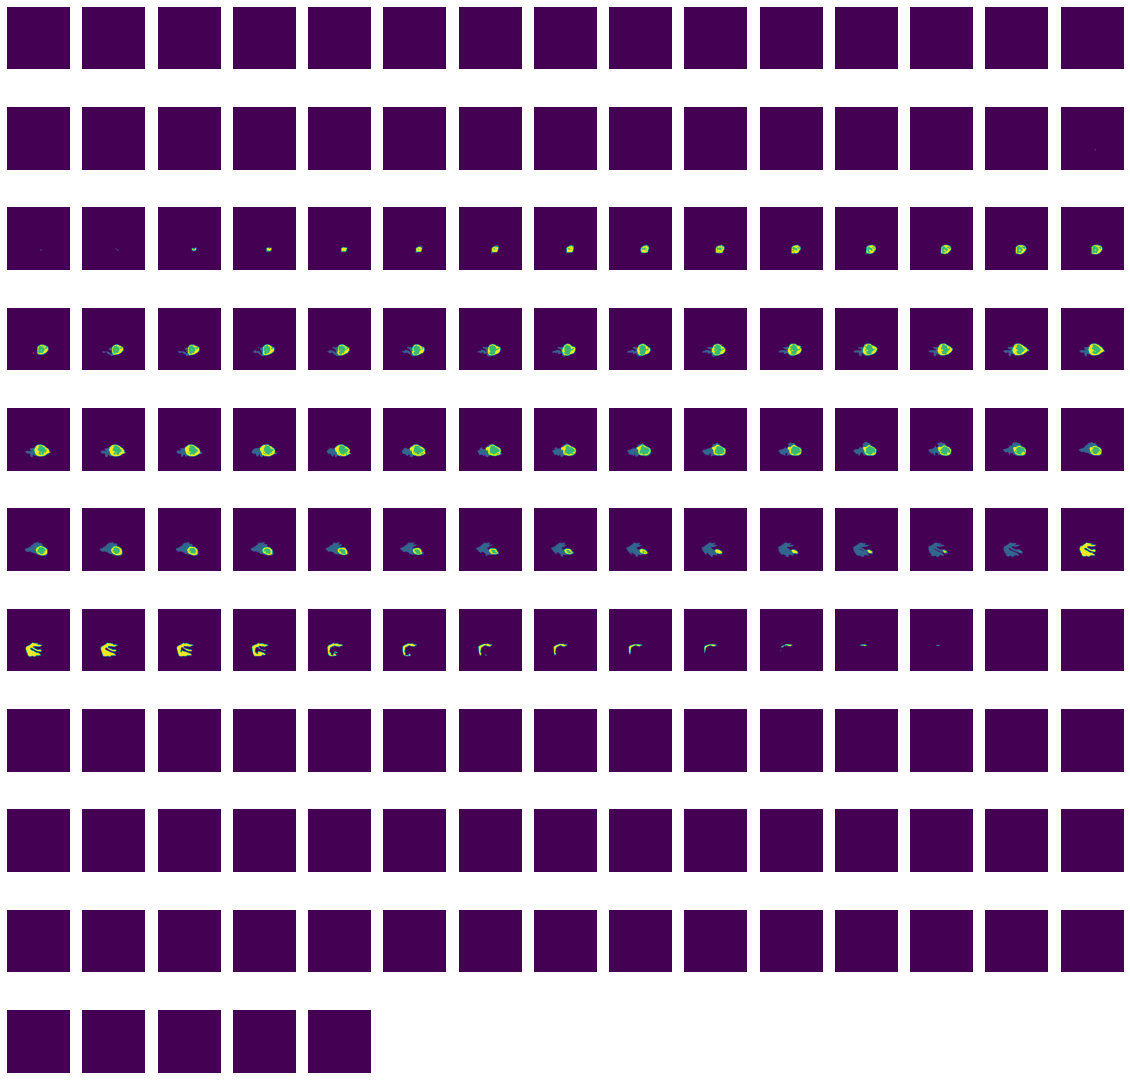

In [ ]:
# Segmentation of brain tumor for previous example

fig = plt.figure(figsize=(20,20))

rows = 11
cols = 15

for i in range(155): 
    _, target = dataset.__getitem__(i)
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(target)
    plt.axis('off')